In [1]:
# import libraries
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import sklearn

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score
from PIL import Image
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# define function to easily resize given images
def resize_images(img_path):
    images=glob.glob(img_path + "/*.jpg") # file name to list, '*' for full text
    
    print(len(images), " images to be resized.")

    # reshaping all images to 28x28 and then saving each one of them
    target_size=(28, 28)
    for img in images:
        old_img=Image.open(img) # opening image
        new_img=old_img.resize(target_size,Image.ANTIALIAS) # resizing
        new_img.save(img, "JPEG") # saving image
    
    print(len(images), " images resized.")

# loading and resizing all images in scissor folder
image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper/scissors"
resize_images(image_dir_path)

# loading and resizing all images in rock folder
image_dir_path = os.getenv('HOME') + '/aiffel/rock_scissor_paper/rock'
resize_images(image_dir_path)

# loading and resizing all images in rock folder
image_dir_path = os.getenv('HOME') + "/aiffel/rock_scissor_paper/paper"
resize_images(image_dir_path)

700  images to be resized.
700  images resized.
700  images to be resized.
700  images resized.
700  images to be resized.
700  images resized.


In [3]:
# function to load all data as imgs and labels
def load_data(img_path, number_of_data=2100):  # ensure to double check the num of data
    img_size=28
    color=3
    # assigning imgs with zero only matrix of total params
    # scissors : 0, rock : 1, paper : 2
    
    # 1-d zero matrix of all params, then reshaping to 4-d tensor
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    # zero matrix for target
    labels=np.zeros(number_of_data,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/scissors/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32) # image data into np.array
        imgs[idx,:,:,:]=img    # allocate img (array) to imgs index
        labels[idx]=0   # scissors : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/rock/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # allocate img (array) to imgs index
        labels[idx]=1   # rock : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # allocate img (array) to imgs index
        labels[idx]=2   # paper : 2
        idx=idx+1
        
    print("학습데이터(x_train)의 이미지 개수는", idx,"입니다.")
    return imgs, labels

image_dir_path = os.getenv("HOME") + "/aiffel/rock_scissor_paper"
(x_train, y_train) = load_data(image_dir_path) # unpacking imgs to x_train and labels to y_train

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

학습데이터(x_train)의 이미지 개수는 2100 입니다.
x_train shape: (2100, 28, 28, 3)
y_train shape: (2100,)


라벨:  0


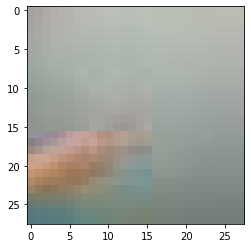

In [4]:
# quick overview of the image
plt.imshow(x_train[0])
print('라벨: ', y_train[0])

In [5]:
# image and label loaded into x_train and y_train
# thus splitting parts of them as test sets using sklearn train_test_split
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.15, stratify=y_train)

# x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.15) # manually splitting train and val sets

print('최소값:',np.min(x_train), ' 최대값:',np.max(x_train)) # check min max of train data
print('최소값:',np.min(x_test), ' 최대값:',np.max(x_test)) # check min max of test data
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)
# print(x_train.shape, x_val.shape, x_test.shape, y_train.shape, y_val.shape, y_test.shape) # this is for manual train val split

최소값: 0  최대값: 255
최소값: 0  최대값: 255
(1785, 28, 28, 3) (315, 28, 28, 3) (1785,) (315,)


In [6]:
# normalizing train set
x_train_norm = x_train / np.max(x_train) # divide by max num to normalize data
print('최소값:',np.min(x_train_norm), ' 최대값:',np.max(x_train_norm)) # after normalizing
x_train_norm.shape

최소값: 0.0  최대값: 1.0


(1785, 28, 28, 3)

In [7]:
# normalizing validation set (use this cell if manually split train and val)
# x_val_norm = x_val / np.max(x_val) # divide by max num to normalize data
# print('최소값:',np.min(x_val_norm), ' 최대값:',np.max(x_val_norm)) # after normalizing
# x_val_norm.shape

In [8]:
# normalizing test set
x_test_norm = x_test / np.max(x_test) # divide by max num to normalize data
print('최소값:',np.min(x_test_norm), ' 최대값:',np.max(x_test_norm)) # after normalizing
x_test_norm.shape

최소값: 0.0  최대값: 1.0


(315, 28, 28, 3)

In [9]:
# constructing a model using keras
model=keras.models.Sequential()
model.add(keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(28,28,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(64, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(64, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

print('Model에 추가된 Layer 개수: ', len(model.layers))

model.summary()

Model에 추가된 Layer 개수:  7
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                102464    
_________________________________________________________________
dense_1 (Dense)              (No

In [10]:
# training a model with method '.compile()' and '.fit()'
model.compile(optimizer='adam',
             loss='sparse_categorical_crossentropy',
             metrics=['accuracy'])

In [11]:
# early stopping in place
early_stopping = EarlyStopping(monitor='val_loss', verbose=1, patience=3)

In [12]:
# using parameter validation_split
history = model.fit(x_train_norm, y_train, epochs=130, validation_split=0.15,
                    verbose=1, callbacks=[early_stopping])

# model.fit(x_train_norm, y_train, epochs=30, validation_data=(x_val, y_val)) # using parameter validation_data

Epoch 1/130
48/48 [==============================] - 3s 10ms/step - loss: 1.1038 - accuracy: 0.3342 - val_loss: 1.0955 - val_accuracy: 0.4030
Epoch 2/130
48/48 [==============================] - 0s 4ms/step - loss: 1.0935 - accuracy: 0.3784 - val_loss: 1.1140 - val_accuracy: 0.3060
Epoch 3/130
48/48 [==============================] - 0s 4ms/step - loss: 1.0718 - accuracy: 0.4515 - val_loss: 1.0394 - val_accuracy: 0.4888
Epoch 4/130
48/48 [==============================] - 0s 4ms/step - loss: 1.0261 - accuracy: 0.4806 - val_loss: 1.0185 - val_accuracy: 0.5448
Epoch 5/130
48/48 [==============================] - 0s 4ms/step - loss: 0.9835 - accuracy: 0.5333 - val_loss: 0.9438 - val_accuracy: 0.5560
Epoch 6/130
48/48 [==============================] - 0s 4ms/step - loss: 0.9431 - accuracy: 0.5643 - val_loss: 0.8981 - val_accuracy: 0.6007
Epoch 7/130
48/48 [==============================] - 0s 4ms/step - loss: 0.9041 - accuracy: 0.5840 - val_loss: 0.8838 - val_accuracy: 0.6082
Epoch 8/130


In [13]:
# checking keys to plot
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

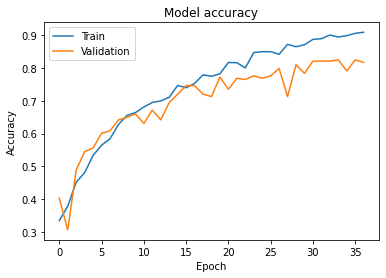

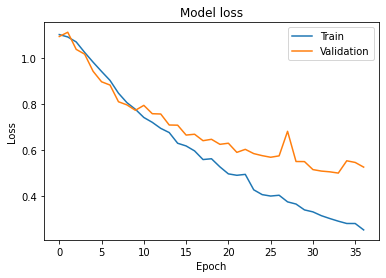

In [17]:
# plotting accuracy and loss to easily pinpoint overfitting
# Ref: https://keras.io/ko/visualization/

# 학습 정확성 값과 검증 정확성 값을 플롯팅 합니다. 
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

# 학습 손실 값과 검증 손실 값을 플롯팅 합니다.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='best')
plt.show()

In [15]:
# evaluate a model by using '.evaluate()' method
test_loss, test_accuracy = model.evaluate(x_test_norm, y_test, verbose=2)
print(f"test_loss: {test_loss}")
print(f"test_accuracy: {test_accuracy}")

10/10 - 0s - loss: 0.4234 - accuracy: 0.8444
test_loss: 0.4234042763710022
test_accuracy: 0.8444444537162781


# 회고

1회차
- 노드에 제공된 학습용 이미지로 300개가 있었고, 테스트용 이미지도 300장이 있어서 이것들로 프로젝트를 진행했보았다.
- 결과가 30-40%대로 나왔어서 hyperparameter들을 만져보았다.
    - epoch를 계속 올리자 테스트 결과가 조금씩 좋아졌지만, 대략 20-30부터는 과적합에 빠져서 train accuracy는 거의 90%로 올라도 test accuracy는 낮아지는 모습을 보였다.
    - 모델안에 hyperparameter(filter 개수)도 숫자를 올리면 조금씩 좋아지다가 내려가는 비슷한 경향을 보였다.
    - 반대로 hyperparameter 숫자들을 내려봤는데, 많이 올리는 것보다 조금 더 좋아지는 경향을 보였다.
- 하지만 최대 40%후반에서 더 올라가지 않아서 정규화를 시도해보았다.
    - test accuracy는 눈꼽만큼 좋아지고, 엄청나게 높아지지는 않았다.
- 계속 진행하다가, 우리 조 자체에서 다들 이미지를 취합해서 더 많은 데이터를 사용해보기로 결정을 했다.
    - 그렇게 총 2100개의 이미지 데이터를 얻을 수 있었다.
- 2100개의 데이터 자체를 sklearn.model_selection에 train_test_split을 이용하여 8:2로 나누었다.
    - epoch를 다시 10에서 시작해 20으로 늘리고 hyperparameter를 처음 모델 만들 때 그대로 진행했더니 기준치를 쉽게 상회하는 점수를 보여주었다.
    - 데이터가 많아짐에 따라 학습 및 테스트의 정확도가 높아지는 결과를 보였다.

2회차
- model의 hyperparameter 중 validation_split을 사용해 보았다.
- 데이터 정규화, epoch=30, hyperparameters(filter 개수) 올리고 나서 test accuracy가 80%대로 쉽게 진입
- sklearn에 train_test_split으로 train/validation/test로 직접 나누어 보는 걸 해보기도 했다
    - train_test_split을 2번 사용하여 직접 3개의 데이터 셋으로 나누어 test까지 계산해 봄
    - train/val/test 비율을 validation_split을 사용할 때와 똑같이 계산해 봤지만, tensorflow model에 validation_split을 이용하는 것이 결과가 더 잘 나왔서 validation_split을 사용하기로 결정했다
- 모델에 accuracy와 loss 값을 시각화 하는 것을 해보니 확실히 overfitting 지점을 보기가 더 편해진 감이 있다.
    - epoch 130 시각화: val loss 내려가다 올라가는 모습을 보였다 (overfitting)
    
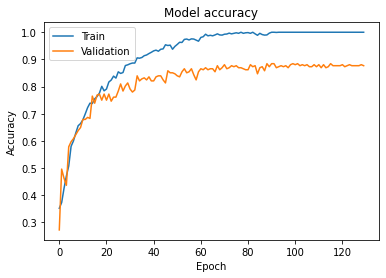

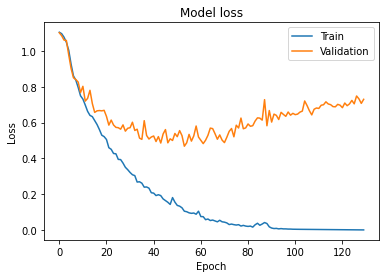

3회차
- Early stopping을 추가해 봤다.
    - 처음에는 val_accuracy를 기준치를 두고 patience를 5로 두니 epoch가 80정도까지 가서 멈추는 모습을 보여주었다.
        - 이유는 학습하면서 출력되는 val_accuracy값이 지그재그 형식으로 왔다갔다 하지만 마지막으로 학습된 좋은 값보다 5번 안에 더 좋은 값이 계속 나오기 때문이었다.
        - 그래서 epoch 130 그래프 에서도 봤듯이 결국 val_accuracy는 학습하면 할수록 좋아지지만 val_loss 값도 계속 올라갔다.
    - val_accuracy를 80%대롤 만들고 val_loss를 줄이는 방향으로 생각을 전환
        - 기준치를 val_loss로 두고 patience는 3으로 설정
        - epoch를 130번 돌린 모델과 비슷한 val_accuracy를 보여주고 훨씬 낮은 val_loss값을 출력했다.
        
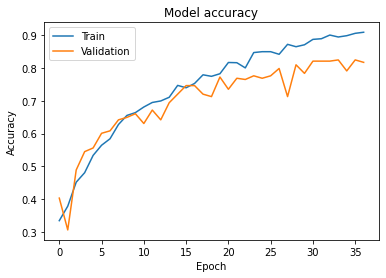

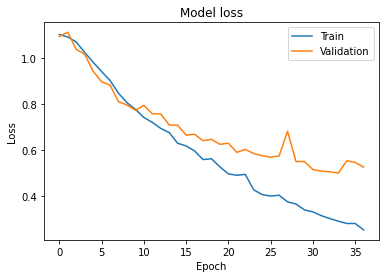

# 더 해볼것

- Kfold/Stratified Kfold